# La Vuelta - Density Based Clustering (DBSCAN)

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.cluster.hierarchy import fcluster

from scipy.spatial.distance import pdist, squareform
from kneed import KneeLocator

In [3]:
dataset = pd.read_csv('../../data/complete_dataset_fe.csv', dtype={'cyclist_team': str})
dataset['date'] = pd.to_datetime(dataset['date'], format='%Y-%m-%d')
dataset = dataset[dataset['race_name'] == 'Vuelta a Espana']

In [4]:
'''
Clustering Features Cyclists:
- cyclist_bmi (ignore: weight)
- height
- mean_delta
- cyclist_climb_power
'''

'\nClustering Features Cyclists:\n- cyclist_bmi (ignore: weight)\n- height\n- mean_delta\n- cyclist_climb_power\n'

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105382 entries, 68 to 589722
Data columns (total 31 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   cyclist_url                   105382 non-null  object        
 1   cyclist_name                  105382 non-null  object        
 2   birth_year                    105382 non-null  int64         
 3   weight                        84483 non-null   float64       
 4   height                        84483 non-null   float64       
 5   nationality                   105382 non-null  object        
 6   race_url                      105382 non-null  object        
 7   race_name                     105382 non-null  object        
 8   points                        105382 non-null  float64       
 9   uci_points                    74670 non-null   float64       
 10  length                        105382 non-null  float64       
 11  climb_total      

In [6]:
# Step 1: Calculate the mean delta for each cyclist
mean_delta = dataset.groupby('cyclist_url')['delta'].mean()
mean_bmi = dataset.groupby('cyclist_url')['cyclist_bmi'].mean()
mean_height = dataset.groupby('cyclist_url')['height'].mean()
mean_cp = dataset.groupby('cyclist_url')['cyclist_climb_power'].mean()

# Step 2: Map the mean delta back to each row
dataset['mean_delta'] = dataset['cyclist_url'].map(mean_delta)
dataset['mean_bmi'] = dataset['cyclist_url'].map(mean_bmi)
dataset['mean_height'] = dataset['cyclist_url'].map(mean_height)
dataset['mean_cp'] = dataset['cyclist_url'].map(mean_cp)


dataset = dataset[['mean_bmi','mean_height', 'mean_delta', 'mean_cp']].drop_duplicates()

In [7]:
# Select relevant columns for clustering
columns_to_use = ['mean_bmi','mean_height', 'mean_delta', 'mean_cp']

data_for_clustering = dataset.dropna() #TODO: remove when we have imputed the missing values

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_clustering)

#### Model Selection

In [8]:
dist = squareform(pdist(data_scaled, 'euclidean'))
min_points = range(2, 20)
optimal_eps = []
optimal_index = []
cluster_count = []
silhouette_scores = []



for i, value in enumerate(min_points):
    k = value - 1 #standard value?
    
    #print("k = ", k)
    
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])

    sorted_distances = sorted(kth_distances)
    indices = range(0, len(kth_distances))
    
    #print("sorted_distances = ", sorted_distances)
    #print("indices = ", indices)

    # Use the KneeLocator to find the knee point
    kneedle = KneeLocator(indices, sorted_distances, curve="convex", direction="increasing")

    #print("kneedle.knee = ", kneedle.knee)
    
    if(kneedle.knee is None):
        optimal_eps.append(None)  # The y-value at the knee
        optimal_index.append(None)  # The x-value (index)
        silhouette_scores.append(None)
        continue
    
    # Get the knee (optimal epsilon)
    optimal_eps.append(sorted_distances[kneedle.knee])  # The y-value at the knee
    optimal_index.append(kneedle.knee)  # The x-value (index)
    
    # Apply DBSCAN
    dbscan = DBSCAN(eps=optimal_eps[i], min_samples=value)
    clusters = dbscan.fit_predict(data_scaled)

    # Add cluster labels to the data
    data_for_clustering['cluster'] = clusters
    number_of_clusters = data_for_clustering['cluster'].nunique()
    cluster_count.append(number_of_clusters)
    
    if(number_of_clusters < 3): # Considering that a cluster is that of outliers, to compite silhouette we need at least 3 clusters here
        silhouette_scores.append(None)
        continue
    
    # Removing outliers so to not include them in silhouette calculation
    no_out_data_scaled = scaler.fit_transform(data_for_clustering[data_for_clustering['cluster'] != -1])
    no_out_labels = dbscan.labels_[dbscan.labels_ != -1]

    # Calculate Silhouette
    silhouette_scores.append(silhouette_score(no_out_data_scaled, no_out_labels))
    

# Creating the DataFrame
model_selection_data = {"min_points": min_points, "optimal_eps": optimal_eps, "optimal_index": optimal_index, "cluster_count": cluster_count, "silhouette_score": silhouette_scores}
model_selection_df = pd.DataFrame(model_selection_data)

model_selection_df

/tmp/ipykernel_24405/2745289044.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_clustering['cluster'] = clusters
/tmp/ipykernel_24405/2745289044.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_clustering['cluster'] = clusters
/tmp/ipykernel_24405/2745289044.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

,min_points,optimal_eps,optimal_index,cluster_count,silhouette_score
0,2,1.086204,1682,4,0.808899
1,3,1.914733,1701,2,NaN
2,4,1.189471,1672,2,NaN
3,5,1.197558,1667,2,NaN
4,6,1.221678,1660,2,NaN
5,7,1.481171,1677,2,NaN
6,8,1.331586,1663,2,NaN
7,9,1.344373,1660,2,NaN
8,10,1.698086,1681,2,NaN
9,11,1.541648,1671,2,NaN


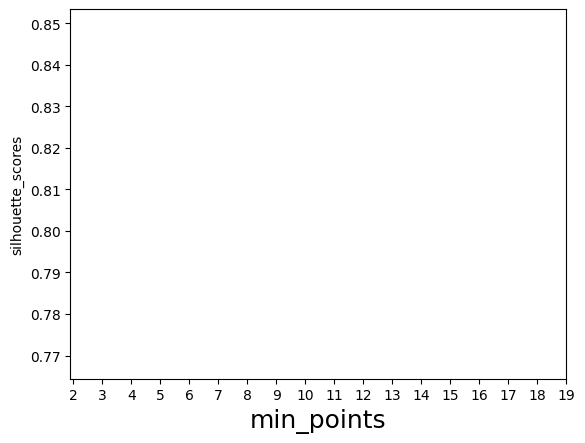

In [9]:
x = model_selection_df[model_selection_df['cluster_count'] > 2]['min_points']
y = model_selection_df[model_selection_df['cluster_count'] > 2]['silhouette_score']

plt.plot(x, y)
plt.ylabel('silhouette_scores')
plt.xlabel('min_points', fontsize=18)
plt.xticks(min_points)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

#### Chosen Parameter Clustering

(1457778,)
(1708, 1708)
Optimal epsilon (eps): 1.086204053558348
Knee point index: 1682


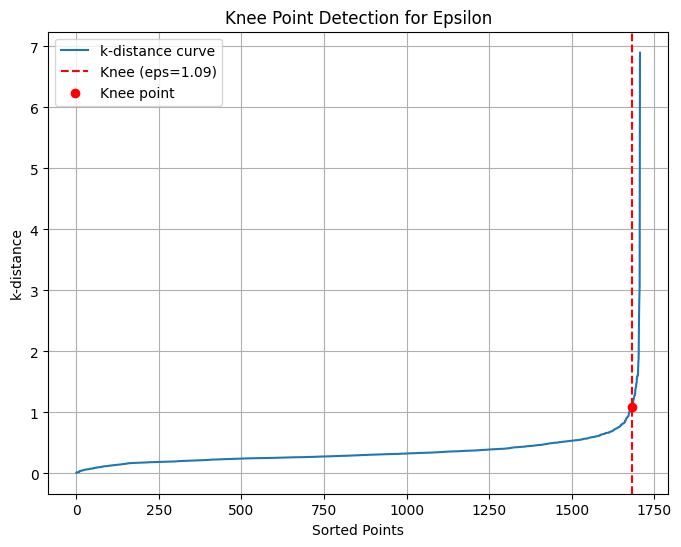

In [10]:
min_points = 2

dist = pdist(data_scaled, 'euclidean') #pair wise distance
print (dist.shape)
dist = squareform(dist) #distance matrix given the vector dist
print(dist.shape)

k = min_points - 1 #standard value?
kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

sorted_distances = sorted(kth_distances)
indices = range(0, len(kth_distances))

# Use the KneeLocator to find the knee point
kneedle = KneeLocator(indices, sorted_distances, curve="convex", direction="increasing")

# Get the knee (optimal epsilon)
optimal_eps = sorted_distances[kneedle.knee]  # The y-value at the knee
optimal_index = kneedle.knee  # The x-value (index)

print(f"Optimal epsilon (eps): {optimal_eps}")
print(f"Knee point index: {optimal_index}")

# Plot the k-distance graph with the knee point marked
plt.figure(figsize=(8, 6))
plt.plot(indices, sorted_distances, label="k-distance curve")
plt.axvline(optimal_index, linestyle="--", color="r", label=f"Knee (eps={optimal_eps:.2f})")
plt.scatter(optimal_index, optimal_eps, color="red", label="Knee point", zorder=5)
plt.xlabel("Sorted Points")
plt.ylabel("k-distance")
plt.title("Knee Point Detection for Epsilon")
plt.legend()
plt.grid()
plt.show()

#### Selection of best eps

In [11]:
# Select relevant columns for clustering
columns_to_use = ['mean_bmi','mean_height', 'mean_delta', 'mean_cp']

data_for_clustering = dataset.dropna() #TODO: remove when we have imputed the missing values

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_clustering)

In [12]:
# Apply DBSCAN
dbscan = DBSCAN(eps=optimal_eps, min_samples=min_points)
clusters = dbscan.fit_predict(data_scaled)

In [13]:
# Add cluster labels to the data
data_for_clustering['cluster'] = clusters

# Display cluster distribution
print(data_for_clustering['cluster'].value_counts())
print(data_for_clustering.head())

cluster
 0    1678
-1      26
 1       2
 2       2
Name: count, dtype: int64
       mean_bmi  mean_height   mean_delta   mean_cp  cluster
68    21.672110        181.0   997.650000  0.000356        0
115   22.282592        181.0   617.150000  0.001796        0
224   21.200991        183.0   598.119048  0.002216        0
626   21.366869        181.0   141.318182  0.004153        0
1478  22.204082        175.0  1023.947368  0.000785        0


/tmp/ipykernel_24405/1605339027.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_clustering['cluster'] = clusters


In [14]:
np.unique(dbscan.labels_, return_counts=True)


(array([-1,  0,  1,  2]), array([  26, 1678,    2,    2]))

In [15]:
# Identify outliers (cluster label -1)
outliers = data_for_clustering[data_for_clustering['cluster'] == -1]
print("\nNumber of outliers:", len(outliers))


Number of outliers: 26


In [16]:
# Analyze the mean and standard deviation of numerical features for each cluster
cluster_stats = data_for_clustering.groupby('cluster').agg(['mean', 'std'])
print("Cluster Statistics:\n", cluster_stats)

Cluster Statistics:
           mean_bmi           mean_height             mean_delta              \
              mean       std        mean        std        mean         std   
cluster                                                                       
-1       23.146859  2.076308  179.461538  12.391064  340.032951  347.010191   
 0       21.149833  1.257276  179.720501   6.190762  527.270493  243.970623   
 1       21.914415  0.618475  190.500000   3.535534  477.134199   39.744911   
 2       20.368827  0.116417  180.000000   1.414214   75.352381   26.708433   

          mean_cp            
             mean       std  
cluster                      
-1       0.009228  0.009617  
 0       0.002033  0.001522  
 1       0.006073  0.000316  
 2       0.013380  0.001001  


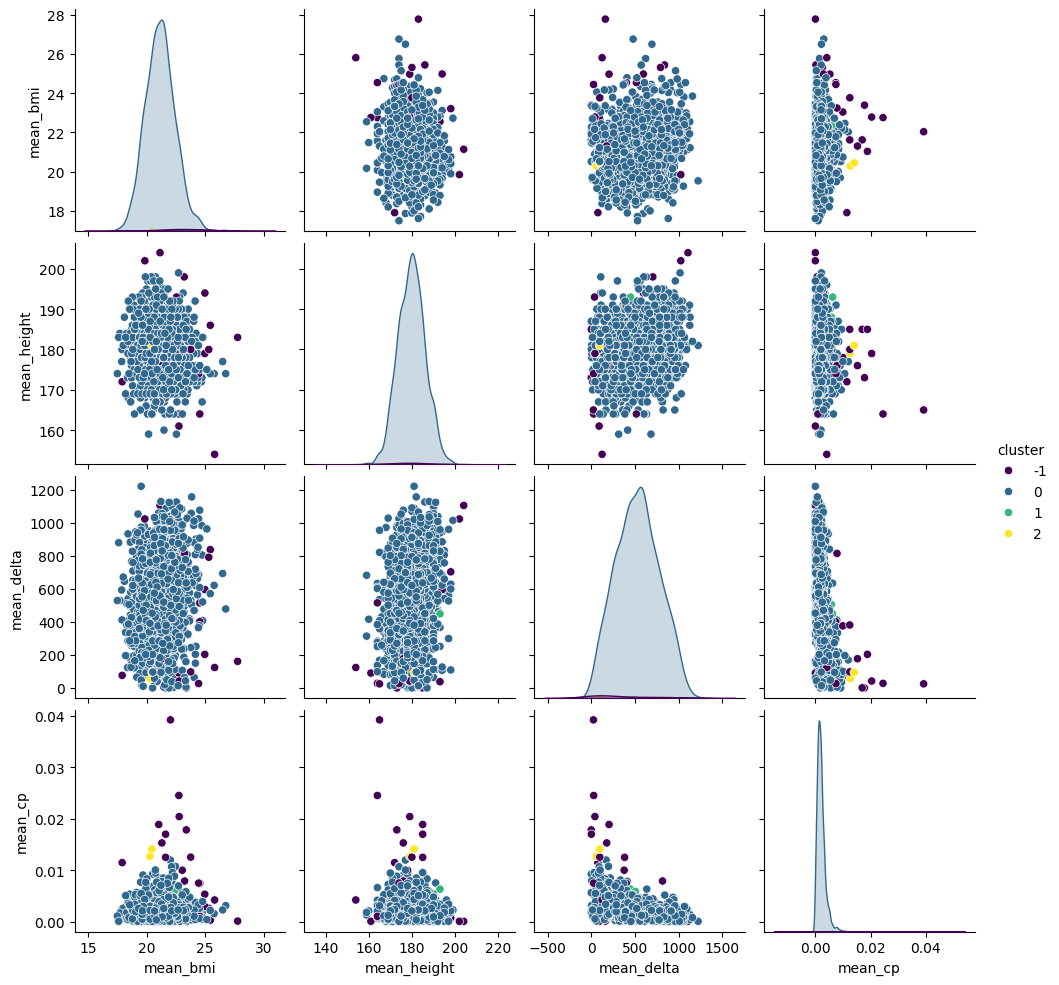

In [17]:

# Pair plot for a subset of columns
data_subset = data_for_clustering[['mean_bmi','mean_height', 'cluster', 'mean_delta', 'mean_cp']]
sns.pairplot(data_subset, hue='cluster', palette='viridis')
plt.show()

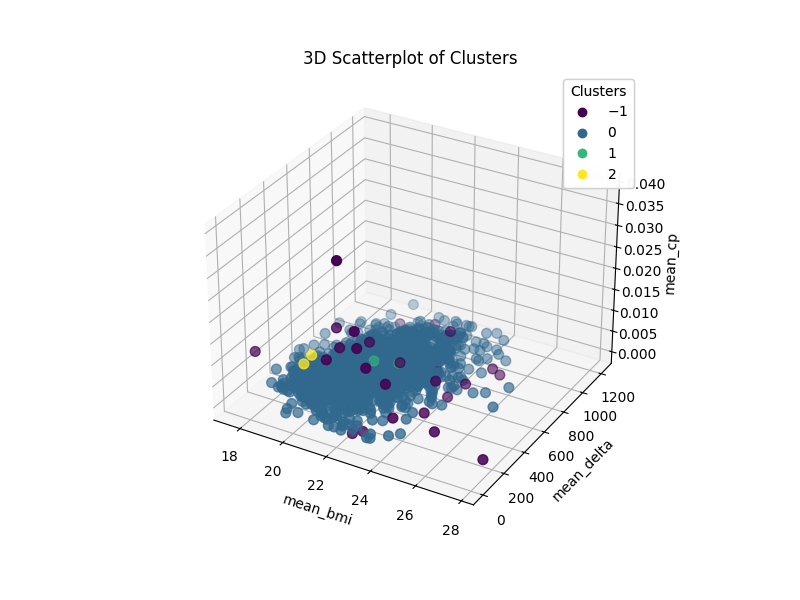

In [18]:
%matplotlib widget

x = data_for_clustering['mean_bmi']  # Prima feature
y = data_for_clustering['mean_delta']  # Seconda feature
z = data_for_clustering['mean_cp']  # Terza feature

# Crea il grafico 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatterplot
scatter = ax.scatter(x, y, z, c=data_for_clustering['cluster'], cmap='viridis', s=50)
ax.set_xlabel('mean_bmi')
ax.set_ylabel('mean_delta')
ax.set_zlabel('mean_cp')

# Aggiungi una legenda (opzionale)
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.title('3D Scatterplot of Clusters')

# Abilita la modalità interattiva
plt.ion()
plt.show()

In [19]:
data_scaled = scaler.fit_transform(data_for_clustering[data_for_clustering['cluster'] != -1])
no_out_labels = dbscan.labels_[dbscan.labels_ != -1]

print('Silhouette %s' % silhouette_score(data_scaled, no_out_labels))

Silhouette 0.8088990497598405
